# Setting up shop

In [2]:
#Setting up shop, insalling libraries & dataviz style sheets

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import seaborn as sns   
import zipfile
import datetime

plt.style.use('ggplot')
pd.set_option('display.max_columns', None) # displays all columns in our dfs so we don't get the ... in the middle

# Hello, data! Who are you?

In [4]:
# Initialize an empty list to store individual dataframes
dfs = []
# Open the zip file containing Spotify data in read mode
zf = zipfile.ZipFile('my_spotify_data_2.zip', 'r')
# Iterate through each file name in the zip file
for name in zf.namelist():
    # Skip files that do not contain 'StreamingHistory' in their name
    if 'Streaming_History_Audio_' not in name:
        continue
    # Read the JSON file into a pandas dataframe and append it to the list of dataframes
    dfs.append(pd.read_json(zf.open(name)))

# Concatenate all dataframes in the list into a single dataframe
df = pd.concat(dfs)

print("Columns:", df.columns.values)
print("Number of streams:", str(df.shape[0]))
print(datetime.timedelta(milliseconds=int(df['ms_played'].sum())))

Columns: ['ts' 'username' 'platform' 'ms_played' 'conn_country' 'ip_addr_decrypted'
 'user_agent_decrypted' 'master_metadata_track_name'
 'master_metadata_album_artist_name' 'master_metadata_album_album_name'
 'spotify_track_uri' 'episode_name' 'episode_show_name'
 'spotify_episode_uri' 'reason_start' 'reason_end' 'shuffle' 'skipped'
 'offline' 'offline_timestamp' 'incognito_mode']
Number of streams: 98835
217 days, 5:06:19.279000


# My Top Artists of 2016 😁

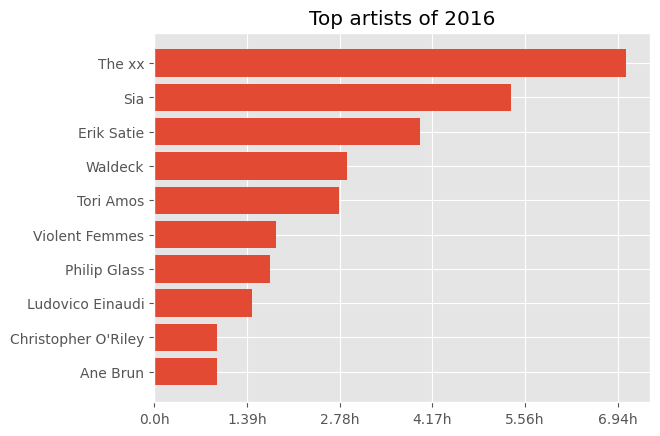

In [9]:
def format_ms(x, pos):
    return str(round(x/(3.6e+6), 2)) + 'h'

# Filter by year, group by artist, sum time played and take top ten.
year_df = df.loc[pd.to_datetime(df['ts']).apply(lambda t: t.year == 2016)]
year_df = year_df.groupby(['master_metadata_album_artist_name'])[['ms_played']].sum()
year_df = year_df.sort_values('ms_played', ascending=False)
year_df = year_df[:10]

fig, ax = plt.subplots()

plt.gca().xaxis.set_major_formatter(format_ms)
ax.barh(year_df.index.values, year_df['ms_played'])
ax.set_title('Top artists of 2016')
ax.invert_yaxis()
plt.show()

# My Top Songs of 2016 😁

In [7]:
df_tracks = df[['master_metadata_album_artist_name', 'master_metadata_track_name', 'ts', 'ms_played', 'spotify_track_uri']]
df_tracks = df_tracks[pd.to_datetime(df_tracks['ts']).apply(lambda t: t.year == 2016)]
df_tracks = df_tracks.groupby(['master_metadata_album_artist_name', 'master_metadata_track_name', 'spotify_track_uri'])
df_tracks = df_tracks.sum('ms_played')
df_tracks = df_tracks.sort_values('ms_played', ascending=False)[:10]
df_tracks = pd.DataFrame(df_tracks.index.values.tolist(), columns=['artist', 'song', 'uri'])
df_tracks

,artist,song,uri
0,The xx,On Hold,spotify:track:4w2iAP3X4FkpPb5kjRdIDx
1,Ane Brun,Halo,spotify:track:6bRgyHxbPkvrHiQFSWxo1B
2,Daft Punk,Veridis Quo,spotify:track:2LD2gT7gwAurzdQDQtILds
3,Sia,Bird Set Free,spotify:track:6MowG7MRVgPfGlCMsXKMJ2
4,Tori Amos,The Power of Orange Knickers (feat. Damien Rice),spotify:track:1M5vcEUX0uAUlwjL8GMdKN
5,Sia,Broken Glass,spotify:track:22iKiimk9wEJWdHlKdtFsA
6,The xx,Infinity,spotify:track:1Dl44SWywsIDdz1GgIp9gG
7,Sia,Space Between,spotify:track:3Wmti6IwvJ2aKeTm9YrZO7
8,Violent Femmes,What You Really Mean,spotify:track:3ZJasx5F3SZs6SW76d8Bjq
9,Various Artists,"Arrival of the Birds / Exodus (From ""The Crims...",spotify:track:775RAZfoS4APXgrol5IwMs


# Top 5 artists over time 🙈


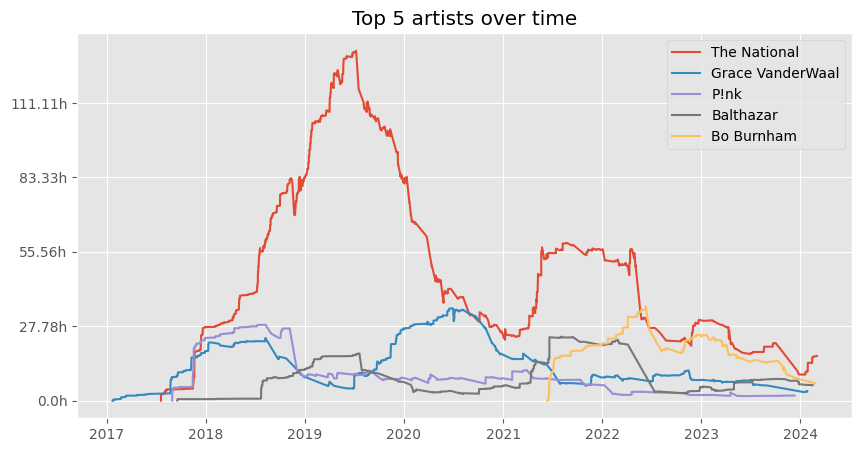

In [10]:
# Determine top artists listened to.
top_artists_df = df.groupby(['master_metadata_album_artist_name'])[['ms_played']]
top_artists_df = top_artists_df.sum().sort_values('ms_played', ascending=False)[:5]
top_artists = [artist for (artist) in top_artists_df.index.values]

fig, ax = plt.subplots(figsize=(10, 5))
for artist in top_artists:
  # Generate rolling sums of total amount of time listening to the artist.
  df2 = df.loc[df['master_metadata_album_artist_name'] == artist][['ts', 'ms_played']]
  df2['ts'] = df2['ts'].apply(pd.to_datetime)
  df2 = df2.sort_values('ts')
  df2 = df2.rolling('365D', on='ts').sum()
  ax.plot(df2['ts'], df2['ms_played'], label=artist)

ax.set_title('Top 5 artists over time')
plt.gca().yaxis.set_major_formatter(format_ms)
plt.legend()
plt.show()

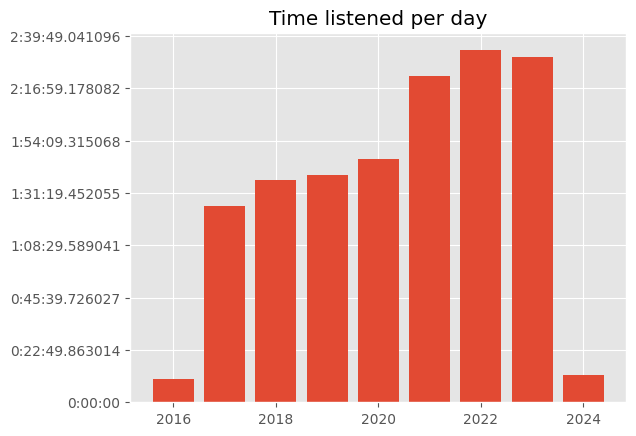

In [14]:


df_years = df[['ts', 'ms_played']].copy()
df_years['year'] = pd.to_datetime(df_years['ts']).apply(lambda t: t.year)
df_years = df_years.groupby(['year'])['ms_played'].sum()

def format_ms_timedelta(x, pos):
    return datetime.timedelta(milliseconds=x) / 365

fig, ax = plt.subplots()
ax.set_title('Time listened per day')
ax.bar(df_years.index, df_years)
ax.yaxis.set_major_formatter(format_ms_timedelta)
plt.show()



# My Top Albums of 2021

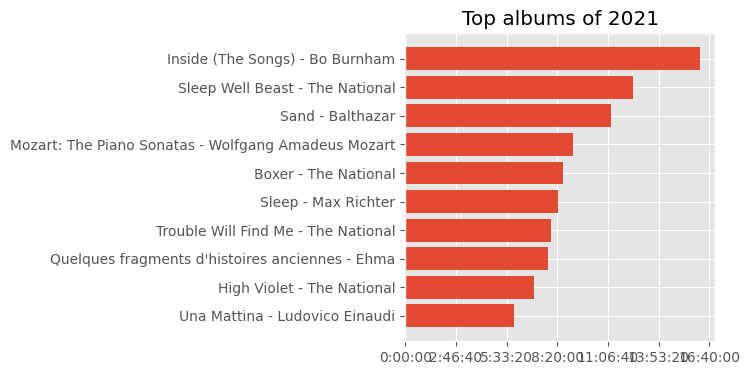

In [28]:
df_album_by_year = df.loc[pd.to_datetime(df['ts']).apply(lambda t: t.year == 2021)]
df_album_by_year = df_album_by_year.groupby(['master_metadata_album_album_name', 'master_metadata_album_artist_name'])
df_album_by_year = df_album_by_year[['ms_played']].sum().sort_values('ms_played', ascending=False)[:10]
albums = [album + " - " + artist for (album, artist) in df_album_by_year.index.values]

def format_ms_timedelta(x, pos):
    return datetime.timedelta(milliseconds=x)

fig, ax = plt.subplots(figsize=(4, 4))
ax.xaxis.set_major_formatter(format_ms_timedelta)
ax.barh(albums, df_album_by_year['ms_played'])
ax.set_title('Top albums of 2021')
ax.invert_yaxis()
plt.show()